In [1]:
# for computing
import numpy as np
import xarray as xr # for reading/writing netcdf
import dask
import pandas as pd # only used for date times

# convenience things
from time import time as timer
import glob # for system ls
from natsort import natsorted # for alphabetical sorting

# for plotting
import matplotlib.pyplot as plt

In [2]:
year=1980
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m']
outvars=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-2m']
months=np.arange(12)+1

# your notebook directory location
repo_dir='/work/hpc/users/kerrie/UN_FAO/repos/py_AEZ_data_prep/'
nb_link='https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/global/03_create_pyaez_daily.ipynb'

# your data directory locations
# ddev_dir='/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/'
ddev_dir='/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/'
# mon_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/'
mon_dir='/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/'
# day_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/'
day_dir='/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/'

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}

source_data=[ddev_dir+'*_DailyDev_'+str(year)+'_5m.nc',mon_dir+'*_monthly_'+str(year)+'_5m.nc']
source_code=nb_link

In [3]:
# daily deviations
ddfiles=natsorted(glob.glob(ddev_dir+'*_DailyDev_'+str(year)+'_*.nc'))
# monthly data
mfiles=natsorted(glob.glob(mon_dir+'*_monthly_'+str(year)+'_*.nc'))

ddfiles,mfiles

(['/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Precip_DailyDev_1980_5m.nc',
  '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Srad_DailyDev_1980_5m.nc',
  '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Tmax-2m_DailyDev_1980_5m.nc',
  '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Tmin-2m_DailyDev_1980_5m.nc',
  '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Vapr_DailyDev_1980_5m.nc',
  '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/Wind-10m_DailyDev_1980_5m.nc'],
 ['/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Precip_monthly_1980_5m.nc',
  '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Srad_monthly_1980_5m.nc',
  '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Tmax-2m_monthly_1980_5m.nc',
  '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Tmin-2m_monthly_1980_5m.nc',
  '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Vapr_monthly_1980_5m.nc',
  '/w

In [ ]:
# # dask single machine (as opposed to using distributed)
# # this function is lazy, i.e. only loads metadata into memory and does no computation

# def lazy_daily_ds(iv):

#     chunks={'time':-1,'lat':360,'lon':1440}
#     with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#         # get daily dev data as dask array
#         var_prime=xr.open_dataset(ddfiles[iv], chunks=chunks)[varnames[iv]]

#         # get monthly data as dask array
#         var_mean=xr.open_dataset(mfiles[iv],chunks=chunks)[varnames[iv]]

#         # save variable metadata
#         varattrs=var_mean.attrs
#         del varattrs['description']

#         # rework metadata for the groupby below
#         var_mean=var_mean.rename({'time':'month'})
#         var_mean['month']=months

#         # daily data lazy comp
#         var_daily=var_prime.groupby('time.month')+var_mean

#         # clean up variable metadata
#         var_daily=var_daily.drop('month')
#         var_daily.attrs=varattrs

#         # convert array to dataset and set global attributes
#         ds=var_daily.to_dataset()
#         ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

#         return ds    

In [ ]:
# def lazy_daily_precip_ds(iv):

#     chunks={'time':-1,'lat':360,'lon':1440}
#     with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#         # get daily fraction data as dask array
#         var_frac=xr.open_dataset(ddfiles[iv], chunks=chunks)[varnames[iv]]

#         # get monthly total as dask array
#         var_mon=xr.open_dataset(mfiles[iv],chunks=chunks)[varnames[iv]]

#         # save variable metadata
#         varattrs=var_mon.attrs
#         del varattrs['description']

#         # rework metadata for the groupby below
#         var_mon=var_mon.rename({'time':'month'})
#         var_mon['month']=months

#         # daily data lazy comp
#         var_daily=var_frac.groupby('time.month')*var_mon

#         # clean up variable metadata
#         var_daily=var_daily.drop('month')
#         var_daily.attrs=varattrs

#         # convert array to dataset and set global attributes
#         ds=var_daily.to_dataset()
#         ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

#         return ds

In [ ]:
# # This function executes the computation and writes the datafile

# def compute_and_write_nc(ds,var,var_encoding):
#     start=timer()

#     # write to file
#     write_job=ds.to_netcdf(day_dir+var+'_daily_'+str(year)+'_5m.nc',
#                 encoding={'lat':lat_encoding,'lon':lon_encoding,'time':time_encoding,var:var_encoding},compute=False)
#     write_job.compute()

#     tasktime = timer()-start
#     print('complete in',tasktime,'s')

In [4]:
def calc_daily_ds(iv):

    print('loading data...')
    start=timer()
    # get daily dev data 
    var_prime=xr.open_dataset(ddfiles[iv])[varnames[iv]].load()
    # get monthly data 
    var_mean=xr.open_dataset(mfiles[iv])[varnames[iv]].load()
    # save variable metadata
    varattrs=var_mean.attrs
    del varattrs['description']
    # rework metadata for the groupby below
    var_mean=var_mean.rename({'time':'month'})
    var_mean['month']=months
    tasktime = timer()-start
    print('complete in',tasktime,'s')

    print('computing daily values...')
    start=timer()
    # calc daily
    var_daily=var_prime.groupby('time.month')+var_mean
    tasktime = timer()-start
    print('complete in',tasktime,'s')
    
    # clean up variable metadata
    var_daily=var_daily.drop('month')
    var_daily.attrs=varattrs

    # convert array to dataset and set global attributes
    ds=var_daily.to_dataset()
    ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

    return ds  

In [5]:
def calc_daily_precip_ds(iv):
    print('loading data...')
    start=timer()
    # get daily dev data 
    var_prime=xr.open_dataset(ddfiles[iv])[varnames[iv]].load()
    # get monthly data 
    var_mean=xr.open_dataset(mfiles[iv])[varnames[iv]].load()
    # save variable metadata
    varattrs=var_mean.attrs
    del varattrs['description']
    # rework metadata for the groupby below
    var_mean=var_mean.rename({'time':'month'})
    var_mean['month']=months
    tasktime = timer()-start
    print('complete in',tasktime,'s')

    print('computing daily values...')
    start=timer()
    # calc daily
    var_daily=var_prime.groupby('time.month')*var_mean  # times here instead of add
    tasktime = timer()-start
    print('complete in',tasktime,'s')
    
    # clean up variable metadata
    var_daily=var_daily.drop('month')
    var_daily.attrs=varattrs

    # convert array to dataset and set global attributes
    ds=var_daily.to_dataset()
    ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

    return ds  

In [6]:
# This function executes the computation and writes the datafile

def compute_and_write_nc(ds,var,var_encoding):
    print('writing netcdf file to',day_dir+var+'_daily_'+str(year)+'_5m.nc')
    start=timer()
    # write to file
    ds.to_netcdf(day_dir+var+'_daily_'+str(year)+'_5m.nc',
                encoding={'lat':lat_encoding,'lon':lon_encoding,'time':time_encoding,var:var_encoding})
    tasktime = timer()-start
    print('complete in',tasktime,'s')

### Precip

In [ ]:
# expect about 1 min run time
iv=0
ds=calc_daily_precip_ds(iv)
ds[varnames[iv]].attrs['units']='mm/day'
# ds
# expect about 3 min run time
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

### Srad

In [ ]:
iv=1
ds=calc_daily_ds(iv)

# save and update metadata
attrs=ds[varnames[iv]].attrs
attrs['units']='W/m2'

# Convert J/m2/day to W/m2
s_per_day=86400
ds[varnames[iv]]=ds[varnames[iv]]/s_per_day
ds[varnames[iv]].attrs=attrs

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

### Tmax-2m

In [ ]:
iv=2
ds=calc_daily_ds(iv)

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

### Tmin-2m

In [ ]:
iv=3
ds=calc_daily_ds(iv)

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

### Vapr --> Rhum

In [ ]:
# lazy get vapor pressure
iv=4
ds=calc_daily_ds(iv)

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

In [10]:
# we have to chunk and parallelize to get Rhum bcz the data is bigger than memory

print('lazy loading data...')
start=timer()

chunks={'time':-1,'lat':540,'lon':1080}  #16

# load daily vapr
vapr=xr.open_dataset(day_dir+'Vapr_daily_1980_5m.nc',chunks=chunks)['Vapr']*0.1

# lazy get daily tmax
tmax=xr.open_dataset(day_dir+'Tmax-2m_daily_1980_5m.nc',chunks=chunks)['Tmax-2m']

# # lazy get daily tmin
tmin=xr.open_dataset(day_dir+'Tmin-2m_daily_1980_5m.nc',chunks=chunks)['Tmin-2m']

tasktime = timer()-start
print('complete in',tasktime,'s')

lazy loading data...
complete in 0.026622533798217773 s


In [11]:
print('lazy compute...')
start=timer()

# compute saturation vapor pressure
vapr_sat=0.5*( np.exp((17.27*tmax)/(tmax+237.3)) + np.exp((17.27*tmin)/(tmin+237.3)) )

tasktime = timer()-start
print('complete in',tasktime,'s')

lazy compute...
complete in 0.017456531524658203 s


In [12]:
print('more lazy compute...')
start=timer()

# compute relative humidity
Rhum=100*(vapr/vapr_sat)

# fix up metadata
Rhum.name='Rhum'
attrs={'standard_name':Rhum.name,'long_name':'relative humidity','units':'%'}
Rhum.attrs=attrs

# convert array to dataset and set global attributes
ds=Rhum.to_dataset()
ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

tasktime = timer()-start
print('complete in',tasktime,'s')

more lazy compute...
complete in 0.005578279495239258 s


In [13]:
# compute and write file, expect about 7 min

start=timer()

var_encoding = {'zlib':True,'dtype':'float32'}
var=Rhum.name

write_job=ds.to_netcdf(day_dir+var+'_daily_'+str(year)+'_5m.nc',
            encoding={'lat':lat_encoding,'lon':lon_encoding,'time':time_encoding,var:var_encoding},compute=False)
write_job.compute()

tasktime = timer()-start
print('complete in',tasktime,'s')

complete in 432.9081332683563 s


### Wind-10m --> Wind-2m

In [14]:
iv=5
ds=calc_daily_ds(iv)

print('interpolating...')
start=timer()
z=10
z_adjust=4.87/(np.log(67.8*z-5.42))
ds=ds*z_adjust

attrs={'standard_name':outvars[iv],'long_name':'2m Wind Speed','units':'m/s'}
ds=ds.rename({varnames[iv]:outvars[iv]})
ds[outvars[iv]].attrs=attrs

tasktime = timer()-start
print('complete in',tasktime,'s')


# expect about 3 min run time
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,outvars[iv],var_encoding)

loading data...
complete in 46.08689856529236 s
computing daily values...
complete in 16.909422636032104 s
interpolating...
complete in 4.728605270385742 s
writing netcdf file to /work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Wind-2m_daily_1980_5m.nc
complete in 142.12430334091187 s


# Check that everything looks ok

In [15]:
dfiles=natsorted(glob.glob(day_dir+'*_daily_'+str(year)+'_*.nc'))
dfiles

['/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Precip_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Rhum_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Srad_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Tmax-2m_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Tmin-2m_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Vapr_daily_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/Wind-2m_daily_1980_5m.nc']

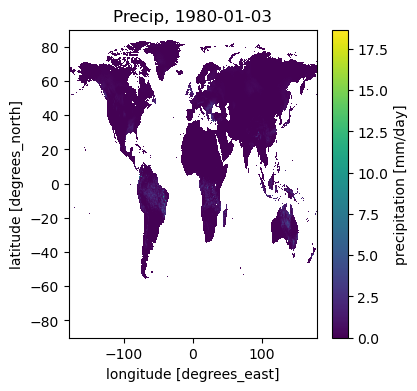

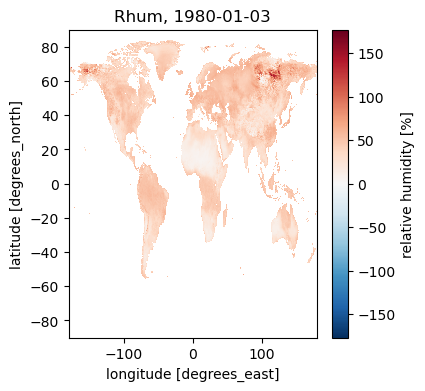

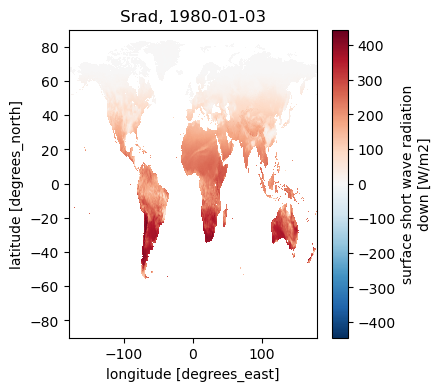

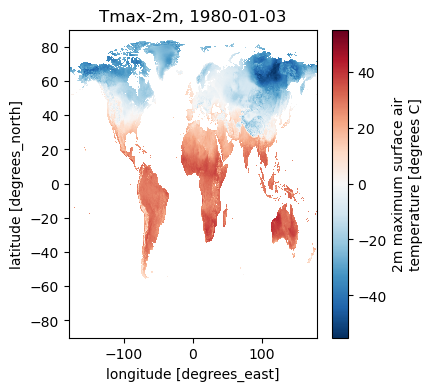

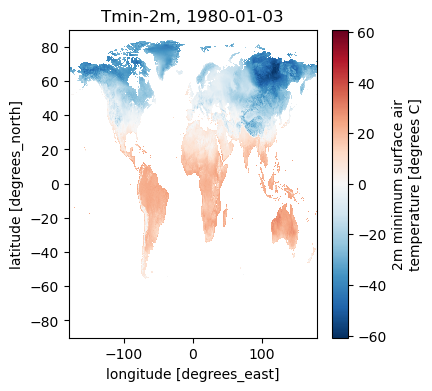

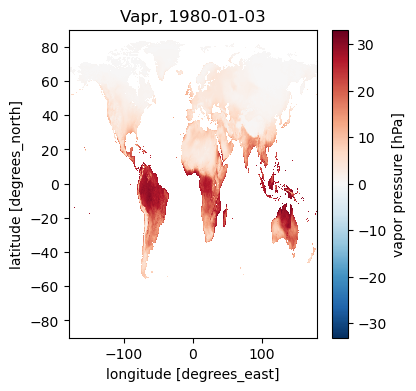

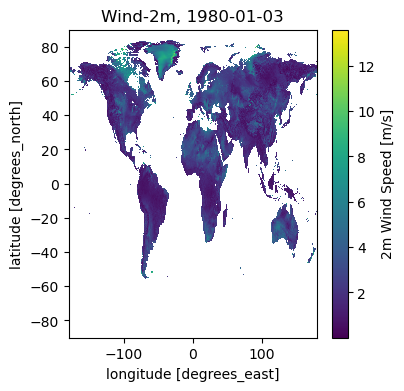

In [16]:
ptime='1980-01-03'
for f in dfiles:
    vname=f.split('/')[-1].split('_')[0]
    var=xr.open_dataset(f)[vname].sel(time=ptime)

    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)

    var.plot(ax=ax)
    plt.title(vname+', '+ptime)    
    plt.show()


### Looks like there is an issue with Rhum. I suspect it is because the Vapr, Tmin-2m, and/or Tmax-2m rst monthly files are slightly different than the tifs Gunther is using. 

In [17]:
rhum=xr.open_dataset(dfiles[1])['Rhum'].load()
rhum.min(),rhum.max()

(<xarray.DataArray 'Rhum' ()>
 array(-10.435808, dtype=float32),
 <xarray.DataArray 'Rhum' ()>
 array(214.18118, dtype=float32))

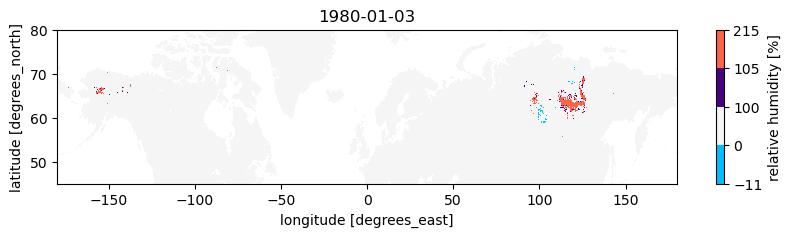

In [18]:
cmap=['deepskyblue','whitesmoke','indigo','tomato']

fig=plt.figure(figsize=(10,2))
ax=plt.subplot(111)

t='1980-01-03'
rhum.sel(time=t,lat=slice(80,45)).plot(ax=ax,levels=[-11,0,100,105,215],colors=cmap)
plt.title(t)
plt.show()